In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
import nb_002
from nb_002c import *

import operator
from random import sample
from torch.utils.data.sampler import Sampler

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'caltech101' # http://www.vision.caltech.edu/Image_Datasets/Caltech101/

# Caltech 101

## Create validation set

In [4]:
#export
class FilesDataset(Dataset):
    def __init__(self, fns, labels, classes=None):
        if classes is None: classes = list(set(labels))
        self.classes = classes
        self.class2idx = {v:k for k,v in enumerate(classes)}
        self.fns = np.array(fns)
        self.y = [self.class2idx[o] for o in labels]
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]
    
    @classmethod
    def from_folder(cls, folder, classes=None, test_pct=0.):
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            fnames = get_image_files(folder/cl)
            fns += fnames
            labels += [cl] * len(fnames)
            
        if test_pct==0.: return cls(fns, labels)
        
        fns,labels = np.array(fns),np.array(labels)
        is_test = np.random.uniform(size=(len(fns),)) < test_pct
        return cls(fns[~is_test], labels[~is_test]), cls(fns[is_test], labels[is_test])

In [5]:
classes = ["airplanes", "Motorbikes", "BACKGROUND_Google", "Faces", "watch", "Leopards", "bonsai",
    "car_side", "ketch", "chandelier", "hawksbill", "grand_piano", "brain", "butterfly", "helicopter", "menorah",
    "trilobite", "starfish", "kangaroo", "sunflower", "ewer", "buddha", "scorpion", "revolver", "laptop", "ibis", "llama",
    "minaret", "umbrella", "electric_guitar", "crab", "crayfish",]

np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, test_pct=0.2)

x = train_ds[1114][0]
classes = train_ds.classes
c = len(classes)

len(train_ds),len(valid_ds),c

(7272, 1872, 102)

## Rectangular affine fix

torch.Size([3, 128, 192])


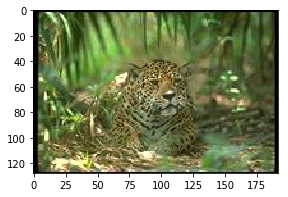

In [6]:
show_image(x, figsize=(6,3), hide_axis=False)
print(x.shape)

In [7]:
rot_m = np.array(rotate(40.)); rot_m

array([[ 0.76604444, -0.64278761,  0.        ],
       [ 0.64278761,  0.76604444,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

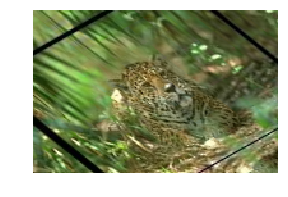

In [8]:
show_image(apply_affine(rot_m)(x), figsize=(6,3))

In [9]:
#export
def affine_grid(x, matrix, size=None):
    h,w = x.shape[1:]
    if size is None: size=x.shape
    matrix[0,1] *= h/w; matrix[1,0] *= w/h
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

nb_002.affine_grid = affine_grid

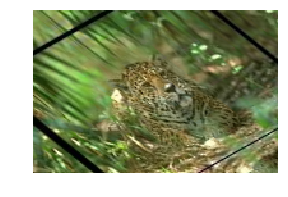

In [10]:
show_image(apply_affine(rot_m)(x), figsize=(6,3))

## Simple crop and pad

In [ ]:
#export
TfmType = IntEnum('TfmType', 'Start Affine Coord Pixel Lighting Crop')
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Pixel:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Crop:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1)*row_pct)
    col = int((x.size(2)-cols+1)*col_pct)
    return x[:, row:row+rows, col:col+cols]

## Crop with padding

In [11]:
#export
@reg_transform
def crop_pad(x, size, padding_mode='reflect',
             row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Crop:
    size = listify(size,2)
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
    row = int((x.size(1)-rows+1)*row_pct)
    col = int((x.size(2)-cols+1)*col_pct)

    x = x[:, row:row+rows, col:col+cols]
    return x.contiguous() # without this, get NaN later - don't know why

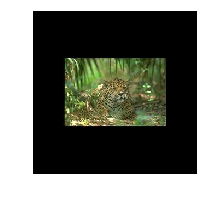

In [12]:
show_image(crop_pad(x, 300, row_pct=0.,col_pct=0., padding_mode='constant'))

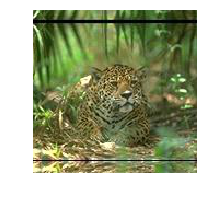

In [13]:
show_image(crop_pad(x, 150))

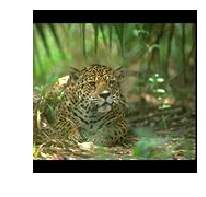

In [14]:
show_image(crop_pad(x, 150, row_pct=0.,col_pct=0.98, padding_mode='constant'))

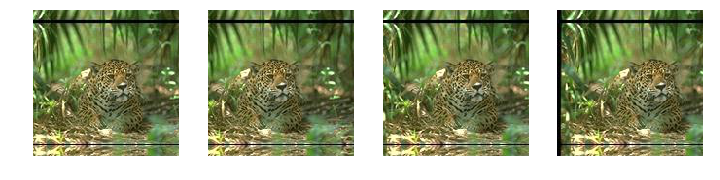

In [15]:
tfm = crop_pad_tfm(row_pct=(0,1.), col_pct=(0,1.))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes.flat: show_image(tfm()(x, size=150), ax)

## Combine crop/resize

In [16]:
#export
def round_multiple(x, mult): return (int(x/mult+0.5)*mult)

def get_crop_target(target_px, target_aspect=1., mult=32):
    target_px = listify(target_px, 2)
    target_r = math.sqrt(target_px[0]*target_px[1]/target_aspect)
    target_c = target_r*target_aspect
    return round_multiple(target_r,mult),round_multiple(target_c,mult)

In [17]:
get_crop_target(220)

(224, 224)

In [18]:
crop_target = get_crop_target(220, 2.);
target_r,target_c = crop_target
crop_target, target_r*target_c

((160, 320), 51200)

In [19]:
_,r,c = x.shape; x.shape

torch.Size([3, 128, 192])

In [20]:
r_ratio = r/target_r
c_ratio = c/target_c
# min -> crop; max -> pad
ratio = max(r_ratio,c_ratio)
r_ratio,c_ratio,ratio

(0.8, 0.6, 0.8)

In [21]:
r2,c2 = round(r/ratio),round(c/ratio); r2,c2

(160, 240)

In [22]:
#export
def get_resize_target(img, crop_target, do_crop=False):
    if crop_target is None: return None
    ch,r,c = img.shape
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

In [23]:
get_resize_target(x, crop_target, False)

(3, 160, 240)

In [24]:
get_resize_target(x, crop_target, True)

(3, 213, 320)

In [25]:
#export
def _apply_affine(img, size=None, padding_mode='reflect', do_crop=False, aspect=None, mult=32,
                  m=None, func=None, crop_func=None, **kwargs):
    if size is not None and not isinstance(size, (tuple,list)):
        size = listify(size,2) if aspect is None else get_crop_target(size, aspect, mult)
    if m is None and func is None and size is None: return img
    resize_target = get_resize_target(img, size, do_crop=do_crop)
    c = affine_grid(img, torch.eye(3), size=resize_target)
    if func is not None: c = func(c, img.size())
    if m is not None: c = affine_mult(c, img.new_tensor(m))
    res = grid_sample(img, c, padding_mode=padding_mode, **kwargs)
    if padding_mode=='zeros': padding_mode='constant'
    if crop_func is not None: res = crop_func(res, size=size, padding_mode=padding_mode)
    return res

def apply_affine(m=None, func=None, crop_func=None):
    return partial(_apply_affine, m=m, func=func, crop_func=crop_func)

nb_002.apply_affine = apply_affine

In [ ]:
#export
def affines_mat(matrices=None):
    if matrices is None or len(matrices) == 0: return None#Chaning here to return None instead of identity
    matrices = [FloatTensor(m) for m in matrices if m is not None]
    return reduce(torch.matmul, matrices, torch.eye(3))

nb_002.affines_mat = affines_mat

((160, 320), torch.Size([3, 160, 240]))

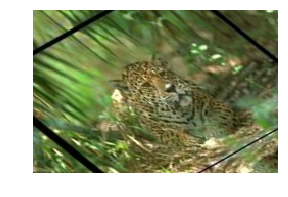

In [26]:
img = apply_affine(rot_m)(x, size=crop_target, do_crop=False)
show_image(img, figsize=(6,3))
crop_target, img.shape

In [27]:
get_crop_target(160,2)

(128, 224)

torch.Size([3, 149, 224])

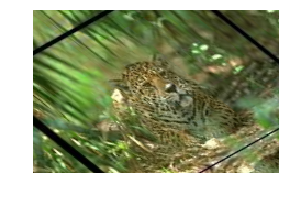

In [28]:
img = apply_affine(rot_m)(x, size=160, aspect=2, do_crop=True)
show_image(img, figsize=(6,3))
img.shape

torch.Size([3, 160, 320])

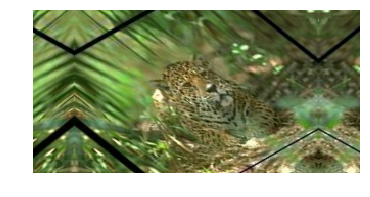

In [29]:
img = apply_affine(rot_m, crop_func=crop_pad)(x, do_crop=False, size=crop_target)
show_image(img, figsize=(6,3))
img.shape

torch.Size([3, 160, 320])

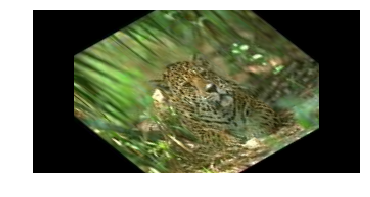

In [30]:
img = apply_affine(rot_m, crop_func=crop_pad)(x, do_crop=False, size=crop_target, padding_mode='zeros')
show_image(img, figsize=(6,3))
img.shape

torch.Size([3, 160, 320])

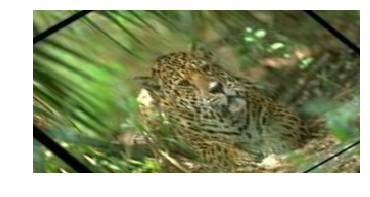

In [31]:
img = apply_affine(rot_m, crop_func=crop_pad)(x, do_crop=True, size=crop_target)
show_image(img, figsize=(6,3))
img.shape

# Fit

## Transform

In [32]:
#export
from nb_002 import _apply_tfm_funcs

def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.tfm_type)
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms,crop_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    affine_func = apply_affine(
        affines_mat(affine_tfms), func=compose(coord_tfms) if len(coord_tfms) != 0 else None, crop_func=compose(crop_tfms))
    return partial(_apply_tfm_funcs,
        compose(pixel_tfms),lighting_func,affine_func,compose(start_tfms))

In [33]:
nb_002.apply_tfms = apply_tfms
import nb_002b
nb_002b.apply_tfms = apply_tfms

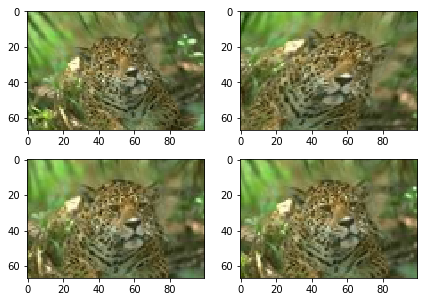

In [34]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.95)),
]

_,axes = plt.subplots(2,2, figsize=(7,5))
for ax in axes.flat:
    show_image(apply_tfms(tfms)(x, do_crop=True, size=(60,100)), ax, hide_axis=False)

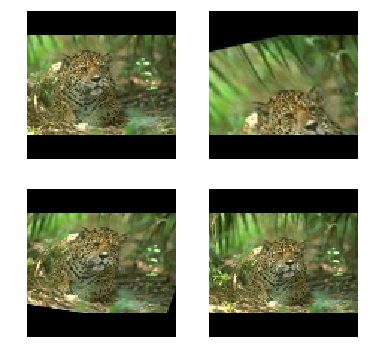

In [35]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.95), row_pct=(0,1), col_pct=(0,1)),
    crop_pad_tfm(row_pct=(0,1), col_pct=(0,1))
]

_,axes = plt.subplots(2,2, figsize=(6,6))
for ax in axes.flat:
    show_image(apply_tfms(tfms)(x, do_crop=False, size=100, padding_mode='zeros'), ax)

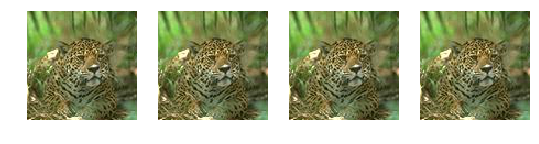

In [36]:
tfms = [crop_tfm(size=100)]
_,axes = plt.subplots(1,4, figsize=(9,3))
for ax in axes.flat: show_image(apply_tfms(tfms)(x, do_crop=True), ax)

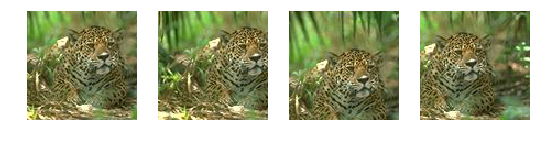

In [37]:
tfms = [crop_tfm(size=100, row_pct=(0,1), col_pct=(0,1))]
_,axes = plt.subplots(1,4, figsize=(9,3))
for ax in axes.flat: show_image(apply_tfms(tfms)(x, do_crop=True), ax)

## Fit

In [38]:
[Image.open(fn).size for fn in np.random.choice(train_ds.fns, 5)]

[(206, 300), (247, 300), (280, 380), (300, 152), (261, 155)]

In [39]:
size = 150

In [40]:
train_tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.5), row_pct=(0,1.), col_pct=(0,1.)),
    crop_pad_tfm(row_pct=(0,1.), col_pct=(0,1.))
]
valid_tfms = [
    zoom_tfm(),
    crop_pad_tfm()
]

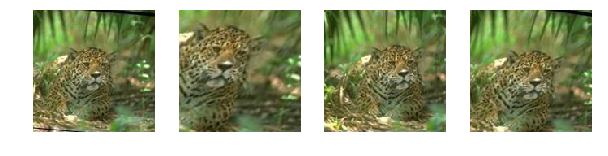

In [41]:
_,axes = plt.subplots(1,4, figsize=(10,5))
for ax in axes.flat:
    show_image(apply_tfms(train_tfms)(x, do_crop=True, size=size), ax)

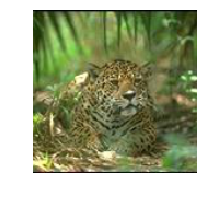

In [42]:
show_image(apply_tfms(valid_tfms)(x, do_crop=True, size=size))

In [43]:
bs = 128

In [45]:
valid_tds = TfmDataset(valid_ds, valid_tfms, size=150, padding_mode='zeros')
data = DataBunch(valid_tds, valid_tds, bs=bs, num_workers=0)
xb,yb = next(iter(data.train_dl))
b = xb.transpose(1,0).reshape(3,-1)
data_mean=b.mean(1).cpu()
data_std=b.std(1).cpu()
data_mean,data_std

(tensor([0.4043, 0.3807, 0.3593]), tensor([0.3675, 0.3570, 0.3562]))

In [ ]:
show_image_batch(data.train_dl, train_ds.classes, 4)

In [ ]:
norm_tfm = normalize_tfm(mean=data_mean, std=data_std)

In [ ]:
valid_tds = TfmDataset(valid_ds, valid_tfms+[norm_tfm], size=150, padding_mode='zeros')
train_tds = TfmDataset(train_ds, train_tfms+[norm_tfm], size=150, padding_mode='zeros')

In [ ]:
data = DataBunch(train_tds, valid_tds, bs=bs, num_workers=12)
len(data.train_dl),len(data.valid_dl)

In [ ]:
model = Darknet([1, 2, 4, 4, 2], num_classes=c, nf=16)
learn = Learner(data, model)
opt_fn = partial(optim.SGD, momentum=0.9)

In [ ]:
learn.fit(1, 0.1, opt_fn=opt_fn)

In [ ]:
# learn.fit(1, 0.2, opt_fn=opt_fn)

In [ ]:
# learn.fit(5, 0.4, opt_fn=opt_fn)

In [ ]:
# learn.fit(5, 0.1, opt_fn=opt_fn)

# Fin